<a href="https://colab.research.google.com/github/Dhanraj7573/Python-Projects/blob/main/Strategy_vs_Buy_%26_Hold%E2%80%9D_Backtester_(SMA_crossover_%2B_risk_metrics).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install requests matplotlib



=== Strategy vs Buy & Hold ===
Symbol: aapl.us | SMA fast=20, slow=50 | fee/trade=0.0500%

Buy & Hold
  Annualized return : 21.15%
  Annualized vol    : 42.56%
  Sharpe (rf=0)     : 0.67
  Max drawdown      : -82.24%

SMA Strategy
  Annualized return : 14.74%
  Annualized vol    : 31.39%
  Sharpe (rf=0)     : 0.60
  Max drawdown      : -79.50%

Worst 5 days (Buy & Hold):
  2000-09-29 : -51.85%
  1987-10-19 : -24.38%
  1993-07-16 : -23.08%
  1987-10-26 : -21.14%
  2008-09-29 : -17.91%

Worst 5 days (Strategy):
  2000-09-29 : -51.85%
  1987-10-19 : -24.38%
  2001-07-18 : -17.21%
  1991-05-01 : -14.12%
  1991-04-15 : -13.27%


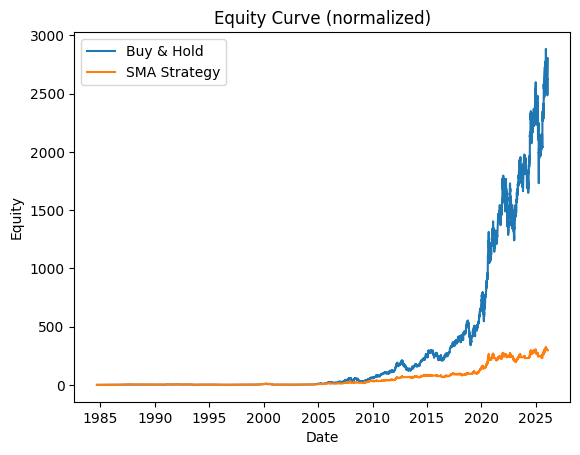

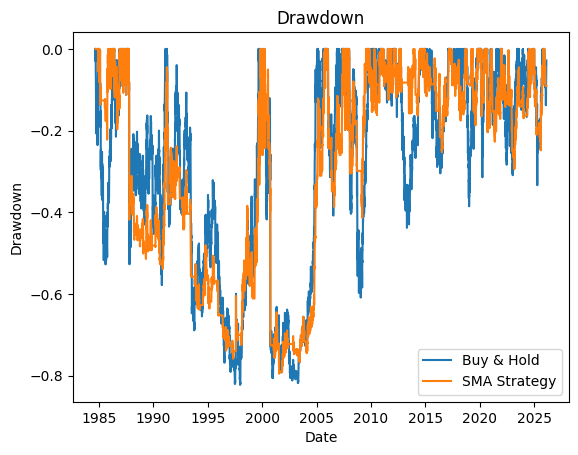

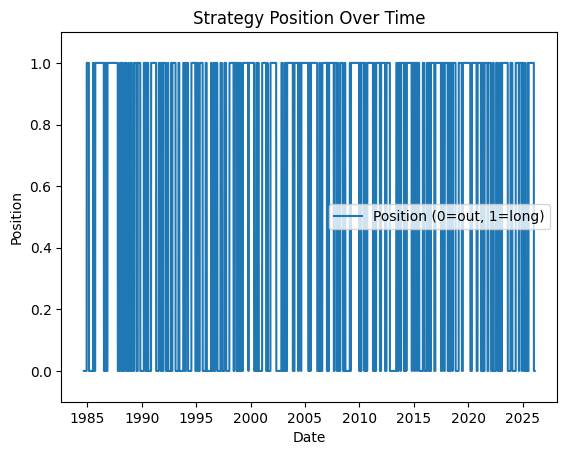

In [2]:
import csv
import io
import math
from typing import Tuple

import numpy as np
import requests


# ----------------------------
# Data fetching (free, no key)
# ----------------------------
def fetch_daily_close(symbol: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Fetch daily close prices from :contentReference[oaicite:2]{index=2} (no API key).
    Returns (dates, closes) in chronological order.
    Example symbols: 'aapl.us', 'msft.us', 'tsla.us'
    """
    url = f"https://stooq.com/q/d/l/?s={symbol.lower()}&i=d"
    r = requests.get(url, timeout=20)
    r.raise_for_status()

    f = io.StringIO(r.text)
    reader = csv.DictReader(f)

    dates, closes = [], []
    for row in reader:
        d = row.get("Date")
        c = row.get("Close")
        if d and c:
            dates.append(d)
            closes.append(float(c))

    if len(closes) < 60:
        raise ValueError("Not enough data returned. Try another symbol like 'aapl.us'.")

    dates = np.array(dates, dtype="datetime64[D]")
    closes = np.array(closes, dtype=float)

    # Ensure oldest -> newest
    if dates[0] > dates[-1]:
        dates = dates[::-1]
        closes = closes[::-1]

    return dates, closes


# ----------------------------
# Core math
# ----------------------------
def simple_returns(prices: np.ndarray) -> np.ndarray:
    return prices[1:] / prices[:-1] - 1.0


def equity_curve(returns: np.ndarray, start: float = 1.0) -> np.ndarray:
    return start * np.cumprod(1.0 + returns)


def rolling_mean(x: np.ndarray, window: int) -> np.ndarray:
    """
    Simple rolling mean using cumulative sums.
    Output has same length as x, with NaN for first window-1 entries.
    """
    out = np.full(len(x), np.nan, dtype=float)
    if len(x) < window:
        return out

    csum = np.cumsum(np.insert(x, 0, 0.0))
    rm = (csum[window:] - csum[:-window]) / window
    out[window - 1:] = rm
    return out


def drawdown(eq: np.ndarray) -> np.ndarray:
    peak = np.maximum.accumulate(eq)
    return eq / peak - 1.0


def max_drawdown(dd: np.ndarray) -> float:
    return float(np.min(dd))


def annualized_return(eq: np.ndarray, periods_per_year: int = 252) -> float:
    """
    From equity curve length N (returns length), approximate annualized return.
    """
    n = len(eq)
    if n <= 1:
        return float("nan")
    total = eq[-1] / eq[0]
    years = n / periods_per_year
    return float(total ** (1.0 / years) - 1.0)


def annualized_vol(returns: np.ndarray, periods_per_year: int = 252) -> float:
    return float(np.std(returns, ddof=1) * math.sqrt(periods_per_year))


def sharpe_ratio(returns: np.ndarray, risk_free: float = 0.0, periods_per_year: int = 252) -> float:
    """
    Simple Sharpe using daily returns. risk_free is annual.
    """
    rf_daily = (1.0 + risk_free) ** (1.0 / periods_per_year) - 1.0
    excess = returns - rf_daily
    vol = np.std(excess, ddof=1)
    if vol == 0:
        return float("nan")
    return float((np.mean(excess) / vol) * math.sqrt(periods_per_year))


def worst_days(returns: np.ndarray, dates_for_returns: np.ndarray, n: int = 5):
    idx = np.argsort(returns)[:n]
    return dates_for_returns[idx], returns[idx]


# ----------------------------
# Strategy: SMA crossover
# ----------------------------
def sma_crossover_strategy(
    prices: np.ndarray,
    fast: int = 20,
    slow: int = 50,
    fee_per_trade: float = 0.0005,  # 0.05% each time you change position
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns:
      position: 0/1 array aligned with returns (length = len(prices)-1)
      strategy_returns: daily strategy returns aligned with returns
    Rule:
      Go long (1) when SMA_fast > SMA_slow, else stay out (0).
    Notes:
      - Position is shifted by 1 day to avoid lookahead bias.
      - Transaction cost is applied when position changes.
    """
    r = simple_returns(prices)
    sma_fast = rolling_mean(prices, fast)
    sma_slow = rolling_mean(prices, slow)

    signal = np.where(sma_fast > sma_slow, 1.0, 0.0)  # aligned with prices length

    # Align signal to returns by dropping first element (since returns start at t=1)
    signal_r = signal[1:]

    # Shift position by 1 day to avoid using today's close to trade today
    pos = np.roll(signal_r, 1)
    pos[0] = 0.0

    # Transaction costs when changing position (0->1 or 1->0)
    trades = np.abs(np.diff(pos, prepend=0.0))
    costs = fee_per_trade * trades

    strat_r = pos * r - costs
    return pos, strat_r


# ----------------------------
# Main
# ----------------------------
def main():
    symbol = "aapl.us"
    fast, slow = 20, 50
    fee = 0.0005
    show_plots = True

    dates, prices = fetch_daily_close(symbol)
    r = simple_returns(prices)
    dates_r = dates[1:]

    # Buy & hold
    eq_bh = equity_curve(r, start=1.0)
    dd_bh = drawdown(eq_bh)

    # Strategy
    pos, r_strat = sma_crossover_strategy(prices, fast=fast, slow=slow, fee_per_trade=fee)
    eq_strat = equity_curve(r_strat, start=1.0)
    dd_strat = drawdown(eq_strat)

    # Metrics
    metrics = {
        "Buy & Hold": {
            "Ann Return": annualized_return(eq_bh),
            "Ann Vol": annualized_vol(r),
            "Sharpe": sharpe_ratio(r),
            "Max DD": max_drawdown(dd_bh),
        },
        "SMA Strategy": {
            "Ann Return": annualized_return(eq_strat),
            "Ann Vol": annualized_vol(r_strat),
            "Sharpe": sharpe_ratio(r_strat),
            "Max DD": max_drawdown(dd_strat),
        },
    }

    print("\n=== Strategy vs Buy & Hold ===")
    print(f"Symbol: {symbol} | SMA fast={fast}, slow={slow} | fee/trade={fee:.4%}")
    for name, m in metrics.items():
        print(f"\n{name}")
        print(f"  Annualized return : {m['Ann Return']:.2%}")
        print(f"  Annualized vol    : {m['Ann Vol']:.2%}")
        print(f"  Sharpe (rf=0)     : {m['Sharpe']:.2f}")
        print(f"  Max drawdown      : {m['Max DD']:.2%}")

    # Worst days (for strategy and buy&hold)
    wd_dates_bh, wd_vals_bh = worst_days(r, dates_r, n=5)
    wd_dates_st, wd_vals_st = worst_days(r_strat, dates_r, n=5)

    print("\nWorst 5 days (Buy & Hold):")
    for d, v in zip(wd_dates_bh, wd_vals_bh):
        print(f"  {str(d)} : {v:.2%}")

    print("\nWorst 5 days (Strategy):")
    for d, v in zip(wd_dates_st, wd_vals_st):
        print(f"  {str(d)} : {v:.2%}")

    if show_plots:
        import matplotlib.pyplot as plt

        plt.figure()
        plt.plot(dates_r, eq_bh, label="Buy & Hold")
        plt.plot(dates_r, eq_strat, label="SMA Strategy")
        plt.title("Equity Curve (normalized)")
        plt.xlabel("Date")
        plt.ylabel("Equity")
        plt.legend()

        plt.figure()
        plt.plot(dates_r, dd_bh, label="Buy & Hold")
        plt.plot(dates_r, dd_strat, label="SMA Strategy")
        plt.title("Drawdown")
        plt.xlabel("Date")
        plt.ylabel("Drawdown")
        plt.legend()

        plt.figure()
        plt.plot(dates_r, pos, label="Position (0=out, 1=long)")
        plt.title("Strategy Position Over Time")
        plt.xlabel("Date")
        plt.ylabel("Position")
        plt.ylim(-0.1, 1.1)
        plt.legend()

        plt.show()


if __name__ == "__main__":
    main()
